## Variational Autoencoder (VAE) Image Generation

In [ ]:
# For this script I used some of the 2nd edition code found here:
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter12_part04_variational-autoencoders.ipynb

In [ ]:
# construct VAE encoder network
import tensorflow.keras as keras
from tensorflow.keras import layers

latent_dim = 2
img_shape = (28, 28, 1)

input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(input_img)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)

shape_before_flattening = keras.backend.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

encoder = keras.Model(input_img, [z_mean, z_log_var], name='encoder')
encoder.summary()

In [3]:
# use z_mean and z_log_var to sample the latent space distribution
# and generate point z
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + (tf.exp(0.5 * z_log_var) * epsilon)
        

In [ ]:
# construct VAE decoder network
import numpy as np

decoder_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)

decoder = keras.Model(decoder_input, x, name='decoder')
decoder.summary()

In [5]:
# construct VAE network with custom train_step() to implement loss function
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        
        self.reconstruction_loss_tracker = keras.metrics.Mean(
                                            name='reconstruction_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        
    @property
    def metrics(self):
        return [self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
                self.total_loss_tracker]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
       
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.total_loss_tracker.update_state(total_loss)
        
        return{
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result(),
            'total_loss': self.total_loss_tracker.result()
        }

In [ ]:
# train VAE network on MNIST dataset
from tensorflow.keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype('float32') / 255.0

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.legacy.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=10, batch_size=128)

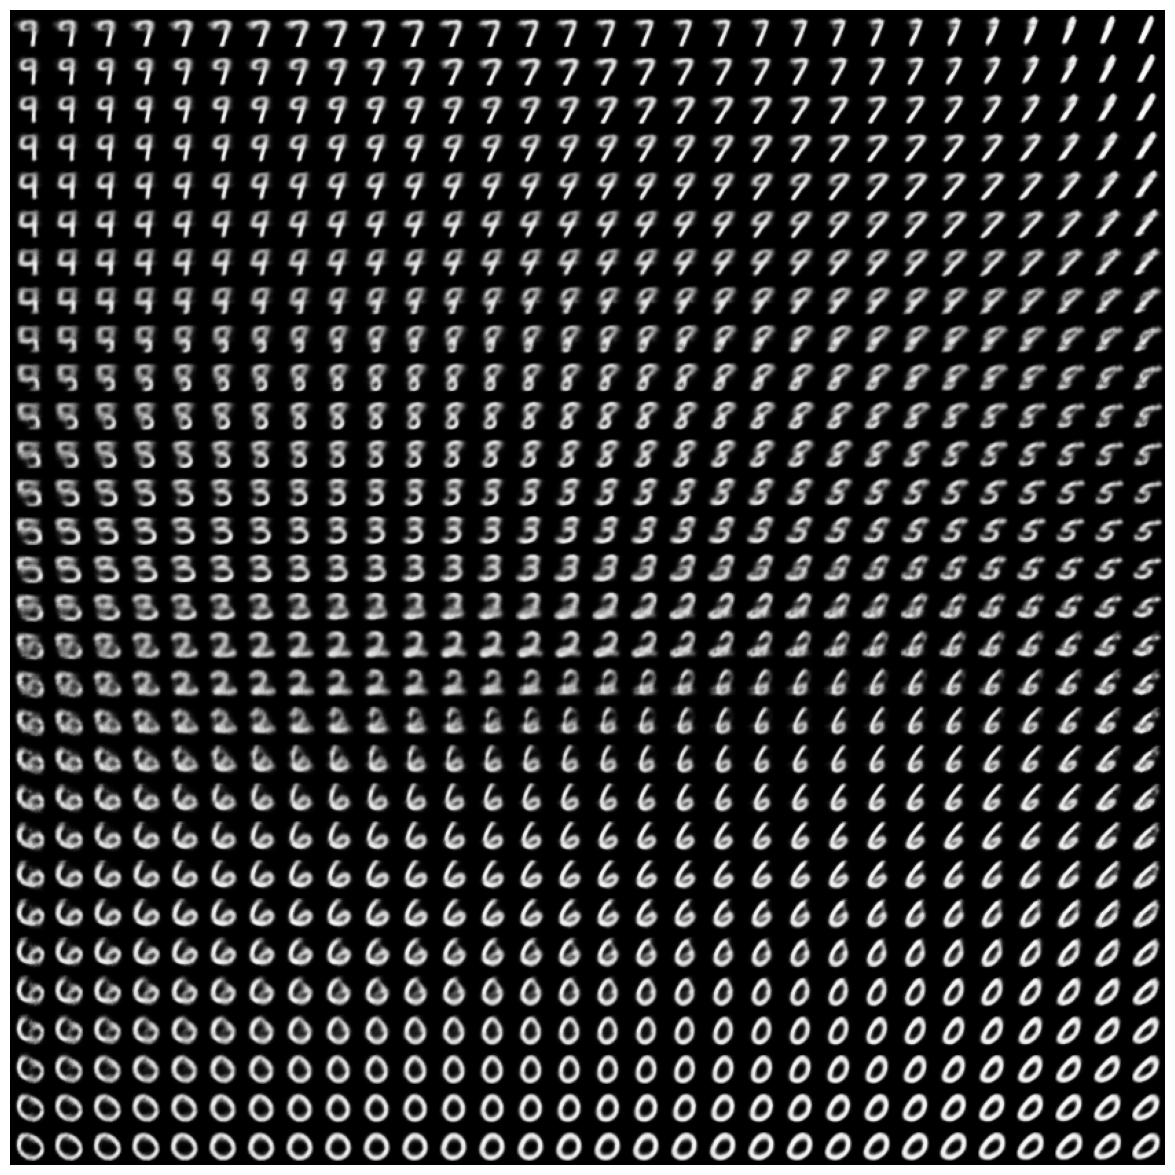

In [14]:
# sample points from 2D latent space and decode to images
import matplotlib.pyplot as plt
from scipy.stats import norm

batch_size = 128
n = 30
digit_size = 28
row_col_size = n * digit_size

figure = np.zeros((row_col_size, row_col_size))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y= norm.ppf(np.linspace(0.05, 0.95, n))

for i, y in enumerate(grid_x):
    for j, x in enumerate(grid_y):
        z_sample = np.array([x, y])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size, verbose=0)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size : (i + 1) * digit_size,
               j * digit_size : (j + 1) * digit_size] = digit

plt.figure(figsize=(15,15))
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap='Greys_r')
plt.show()        